In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

from typing import Callable

from IPython import display
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import torch
import numpy as np





def test_agent(env: gym.Env, policy: Callable, episodes: int = 10) -> None:
    plt.figure(figsize=(8, 8))
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, _, done, _ = env.step(action)
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state




def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    """
    Seeds all the sources of randomness so that experiments are reproducible.
    Args:
        env: the environment to be seeded.
        seed: an integer seed.
    Returns:
        None.
    """
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch._set_deterministic(True)






#from utils import test_agent, plot_stats, seed_everything

In [90]:
#Run this


import time
st=time.time()
import pickle
print("Starting...")
import matplotlib.pyplot as plt
import pandas as pd
import copy
%matplotlib inline
import dask
import warnings
import numpy as np
from dask import delayed
from scipy.stats import qmc
device = ["cuda", "cpu"][1]
import os
import time
nx= 4# number of combinations
episodes =600
epsilontypesi= ["linear", "exponential", "constant"]
epsilontypei= epsilontypesi[1]
epsiloni= 0.2
batchi= int(32)
experiment= "expe3"

def trainmodelr(alphai, gammai, epsiloni, q_network, policyi, episodesi,env, epsilontypei, batchi):
    
    def deep_q_learning(q_network, policy=policyi, episodes=episodesi, alpha=alphai, gamma=gammai,
                        epsilon=epsiloni,epsilontype=epsilontypei,batch_size=batchi):
    
        class ReplayMemory:
            def __init__(self, capacity=100000):
                self.capacity = capacity
                self.memory = []
                self.position = 0
            def insert(self, transition):
                if len(self.memory) < self.capacity:
                    self.memory.append(None)
                self.memory[self.position] = transition
                self.position = (self.position + 1) % self.capacity

            def sample(self, batch_size):
                assert self.can_sample(batch_size)

                batch = random.sample(self.memory, batch_size)
                batch = zip(*batch)
                return [torch.cat([item.to(device) for item in items]) for items in batch]

            def can_sample(self, batch_size):
                return len(self.memory) >= batch_size * 10

            def __len__(self):
                return len(self.memory)
            
        episodemax= episodes
        class EGreedyLinearStrategy():
            def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=episodemax):
                self.t = 0
                self.epsilon = init_epsilon
                self.init_epsilon = init_epsilon
                self.min_epsilon = min_epsilon
                self.decay_steps = decay_steps
                self.exploratory_action_taken = None

            def _epsilon_update(self):
                epsilon = 1 - self.t / self.decay_steps
                epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
                epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
                self.t += 1
                return epsilon

            def select_action(self, model, state):
                self.exploratory_action_taken = False
                with torch.no_grad():
                    q_values = model(state).cpu().detach().data.numpy().squeeze()

                if np.random.rand() > self.epsilon:
                    action = np.argmax(q_values)
                else: 
                    action = np.random.randint(len(q_values))

                self.epsilon = self._epsilon_update()
                self.exploratory_action_taken = action != np.argmax(q_values)
                return action

        class EGreedyExpStrategy():
            def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=episodemax):
                self.epsilon = init_epsilon
                self.init_epsilon = init_epsilon
                self.decay_steps = decay_steps
                self.min_epsilon = min_epsilon
                self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
                self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
                self.t = 0
                self.exploratory_action_taken = None

            def _epsilon_update(self):
                self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
                self.t += 1
                return self.epsilon

            def select_action(self, model, state):
                self.exploratory_action_taken = False
                with torch.no_grad():
                    q_values = model(state).detach().cpu().data.numpy().squeeze()

                if np.random.rand() > self.epsilon:
                    action = np.argmax(q_values)
                else:
                    action = np.random.randint(len(q_values))

                self._epsilon_update()
                self.exploratory_action_taken = action != np.argmax(q_values)
                return action
    
    
        optim = AdamW(q_network.parameters(), lr=alpha)
        memory = ReplayMemory()
        stats = {'MSE Loss': [], 'Returns': []}
        target_q_network= copy.deepcopy(q_network).to(device).eval()
        q_network.to(device)
        for episode in tqdm(range(1, episodes + 1)):
            state = env.reset()
            done = False
            ep_return = 0
            
            while not done:
                
                if epsilontype=='exponential':

                    s=EGreedyExpStrategy()
                    epsiloni= s._epsilon_update()

                elif epsilontype=='linear':
                    s= EGreedyLinearStrategy()
                    epsiloni= s._epsilon_update()

                elif epsilontype=='constant':
                    s=epsiloni
                    
                action = policy(state, epsiloni)
                next_state, reward, done, _ = env.step(action)
                memory.insert([state, action, reward, done, next_state])
                if memory.can_sample(batch_size):
                    state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)              
                    qsa_b = q_network(state_b.to(device)).gather(1, action_b)
                    next_qsa_b = target_q_network(next_state_b.to(device))
                    next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                    target_b = reward_b + ~done_b * gamma * next_qsa_b
                    loss = F.mse_loss(qsa_b, target_b)
                    q_network.zero_grad()
                    loss.backward()
                    optim.step()
                    stats['MSE Loss'].append(loss.item())  

                state = next_state
                ep_return += reward.item()

            stats['Returns'].append(ep_return)

            if episode % 10 == 0:
                target_q_network.load_state_dict(q_network.state_dict())

        return stats

    statsi= deep_q_learning(q_network.to(device), policy)
    
    return {'stats':statsi, 'q_network': q_network}


#  CODE STARTS
trials= {'alpha':np.random.uniform(0.0001, 0.001,nx),
         'gamma':np.random.uniform(0.95, 1,nx)}

tableh= pd.DataFrame(trials)
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=nx)
l_bounds = [0.03, 0.1]
u_bounds = [0.20, 1]

A= qmc.scale(sample, l_bounds, u_bounds)
tableh['alpha']=A[:,0]
tableh['gamma']=A[:,1]

tableh['epsilontype']= epsilontypei
tableh['epsilonmin']= 0.1
tableh['epsilonmax']= 1
tableh['epsilon']= epsiloni
tableh['episodes']= episodes
tableh['batch']= batchi
parallelize='local'
print("Starting ",  parallelize)
warnings.simplefilter(action='ignore', category=FutureWarning)
frame= tableh
nreal=len(frame)
ncpus= 4
bi= int(nreal/ncpus)
frame['seed']=int(41)
mask= frame['seed']==42
nlen= len(frame[mask])
nseedtochange= list(frame[~mask].index)
print(nseedtochange)
batcheson=False
if batcheson==True:

    l = np.array_split(np.array(nseedtochange),bi)
    
else:
    l= np.array_split(np.array(nseedtochange),1)

print(bi)
counter=0
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state.to(device)).detach()
        return torch.argmax(av, dim=-1, keepdim=True)
 
model_list=[]  

print("Running episodes ", episodes, epsilontypei)
for ix, batch in enumerate(l):
    print("counter ", counter)
    some_list= []
    for modelnum in list(batch):
            model_list.append(modelnum)
            print(modelnum, "modelnum")
            alphai= frame['alpha'].iloc[modelnum]
            #epsiloni= frame['epsilon'].iloc[modelnum]
            gammai= frame['gamma'].iloc[modelnum]
            
            class PreprocessEnv(gym.Wrapper):
                def __init__(self, env):
                    gym.Wrapper.__init__(self, env)
                    
                def reset(self):
                    obs = self.env.reset()
                    return torch.from_numpy(obs).unsqueeze(dim=0).float()

                def step(self, action):
                    action = action.item()
                    next_state, reward, done, info = self.env.step(action)
                    next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
                    reward = torch.tensor(reward).view(1, -1).float()
                    done = torch.tensor(done).view(1, -1)
                    return next_state, reward, done, info
                
            env=gym.make('LunarLander-v2')
            env.reset()
            seed_everything(env,42)
            print("Seed")
            env = PreprocessEnv(env)
            state = env.reset()
            action = torch.tensor(0)
            next_state, reward, done, _ = env.step(action)
            print(f"Sample state: {state}")
            print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")
            state_dims= env.observation_space.shape[0]
            num_actions= env.action_space.n
            print(state_dims, num_actions)
            q_network= nn.Sequential(
            nn.Linear(state_dims, 128),
            nn.ReLU(), 
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, num_actions))
            
            
            
            if parallelize=='local':
                print("Computing...", modelnum)
                dicinput_some= trainmodelr(alphai, gammai, epsiloni, q_network, policy, episodes,env, epsilontypei, batchi)
                some_list.append(dicinput_some)

            elif parallelize=='ray':
                if ray.is_initialized()==False:
                    print("Initializing ", parallelize)
                    ray.shutdown()
                    ray.init(num_cpus=ncpus, num_gpus=0)
                    test_remote= ray.remote(trainmodelr)
                    print("Ray Initialized")
                    print("Starting ...")
                    
                print("Computing...", modelnum)

                dicinput_some= test_remote.remote((alphai, gammai, epsiloni, q_network,
                                                   policy, episodes,env, epsilontypei, batchi))
                some_list.append(dicinput_some)
                
            elif parallelize=='dask':
                if modelnum==0:
                    print("Initializing ", parallelize)

                print("Computing...", modelnum)
                dicinput_some= delayed(trainmodelr)(alphai, gammai, epsiloni, q_network,
                                                    policy, episodes,env, epsilontypei, batchi)
                some_list.append(dicinput_some)
                
    print("Done")
    if parallelize=='dask':
        print("Obtaining list...")
        graph = dask.delayed()(some_list)
        print("List Obtained...")
        computed_list = graph.compute()
        
    elif parallelize=='ray':

        print("Obtaining list...")
        computed_list= ray.get(some_list)
        print("List Obtained...")

    elif parallelize=='local':
        computed_list= some_list

    for modelnum_new,dicix in enumerate(computed_list):
        print("updating models", modelnum_new)
        modelnumi= model_list[modelnum_new]
        dicbunker= {'seed':int(42)}
        
        for key in list(dicbunker.keys()):
            try:
                frame[key].iloc[modelnumi]= dicbunker[key]

            except:
                continue
                
        print(modelnum_new)
       
        namef="{0}_modelnum{1}.pkl".format(experiment,modelnum_new)
        pickle.dump( dicix, open( namef, "wb" ) )
        print("Done")


et= time.time()
print((et-st)/(60*60))
namef="{0}_tableh.pkl".format(experiment)
pickle.dump(tableh, open( namef, "wb" ) )
print("Done")


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

Starting...
Starting  local
[0, 1, 2, 3]
1
Running episodes  600 exponential
counter  0
0 modelnum
Seed
Sample state: tensor([[ 0.0023,  1.4181,  0.2326,  0.3205, -0.0027, -0.0527,  0.0000,  0.0000]])
Next state: tensor([[ 0.0046,  1.4248,  0.2323,  0.2948, -0.0053, -0.0521,  0.0000,  0.0000]]), Reward: tensor([[1.1450]]), Done: tensor([[False]])
8 4
Computing... 0


100%|██████████| 600/600 [02:41<00:00,  3.71it/s]


1 modelnum
Seed
Sample state: tensor([[ 0.0023,  1.4181,  0.2326,  0.3205, -0.0027, -0.0527,  0.0000,  0.0000]])
Next state: tensor([[ 0.0046,  1.4248,  0.2323,  0.2948, -0.0053, -0.0521,  0.0000,  0.0000]]), Reward: tensor([[1.1450]]), Done: tensor([[False]])
8 4
Computing... 1


100%|██████████| 600/600 [02:50<00:00,  3.51it/s]


2 modelnum
Seed
Sample state: tensor([[ 0.0023,  1.4181,  0.2326,  0.3205, -0.0027, -0.0527,  0.0000,  0.0000]])
Next state: tensor([[ 0.0046,  1.4248,  0.2323,  0.2948, -0.0053, -0.0521,  0.0000,  0.0000]]), Reward: tensor([[1.1450]]), Done: tensor([[False]])
8 4
Computing... 2


100%|██████████| 600/600 [02:56<00:00,  3.40it/s]


3 modelnum
Seed
Sample state: tensor([[ 0.0023,  1.4181,  0.2326,  0.3205, -0.0027, -0.0527,  0.0000,  0.0000]])
Next state: tensor([[ 0.0046,  1.4248,  0.2323,  0.2948, -0.0053, -0.0521,  0.0000,  0.0000]]), Reward: tensor([[1.1450]]), Done: tensor([[False]])
8 4
Computing... 3


100%|██████████| 600/600 [02:55<00:00,  3.41it/s]


Done
updating models 0
0
Done
updating models 1
1
Done
updating models 2
2
Done
updating models 3
3
Done
0.1905247875716951
Done


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [91]:
import pickle 
# open a file, where you stored the pickled data
f = open("{0}_tableh.pkl".format(experiment), 'rb')
tableh = pickle.load(f)
f.close()
modelnum_new=0
f = open("{0}_modelnum{1}.pkl".format(experiment,modelnum_new), 'rb')
all = pickle.load(f)
f.close()

q_network=all['q_network']
stats = all['stats']

tableh






,alpha,gamma,epsilontype,epsilonmin,epsilonmax,epsilon,episodes,batch,seed
0,0.056875,0.855659,exponential,0.1,1,0.2,600,32,42
1,0.136842,0.473521,exponential,0.1,1,0.2,600,32,42
2,0.190462,0.130837,exponential,0.1,1,0.2,600,32,42
3,0.098933,0.554085,exponential,0.1,1,0.2,600,32,42


In [40]:
env=gym.make('LunarLander-v2')
env.reset()
seed_everything(env,42)
print("Seed")
env = PreprocessEnv(env)
state = env.reset()

Seed


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

In [ ]:
stats.keys()

dict_keys(['MSE Loss', 'Returns'])

KeyboardInterrupt: ignored

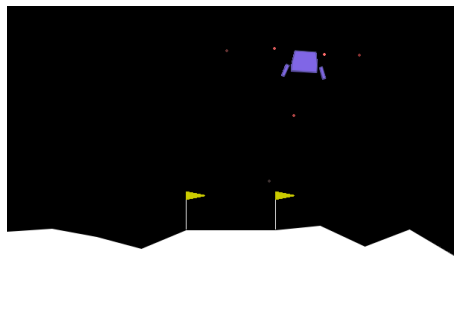

In [92]:
test_agent(env, policy,2)

In [93]:
#TestAgent evaluation
#plt.figure(figsize=(8, 8))



for modelnum_new in range(len(tableh)):
  print(modelnum_new)
  stats2={'Returns':[]}

  episodes= tableh['episodes'].iloc[0]
  episodes= 120
  f = open("{0}_modelnum{1}.pkl".format(experiment,modelnum_new), 'rb')
  all = pickle.load(f)
  f.close()
  q_network= all['q_network']
  for episode in range(episodes):
      state = env.reset()
      done = False
      ep_return=0
      while not done:
          p = policy(state)
          if isinstance(p, np.ndarray):
              action = np.random.choice(4, p=p)
          else:
              action = p

          #next_state, _, done, _ = env.step(action)
          next_state, reward, done, _ = env.step(action)
          ep_return += reward.item()
          state = next_state

      stats2['Returns'].append(ep_return)

  namef="{0}_modelnum{1}_eval.pkl".format(experiment, modelnum_new)
  pickle.dump( stats2, open( namef, "wb" ) )
  print("Done")
  print(modelnum_new, "done")


  
    






0
Done
0 done
1
Done
1 done
2
Done
2 done
3
Done
3 done


In [68]:
tableh

,alpha,gamma,epsilontype,epsilonmin,epsilonmax,epsilon,episodes,batch,seed
0,0.087064,0.99,linear,0.1,1,0.2,400,32,42
1,0.001495,0.99,linear,0.1,1,0.2,400,32,42
2,0.047267,0.99,linear,0.1,1,0.2,400,32,42
3,0.032722,0.99,linear,0.1,1,0.2,400,32,42
4,0.062471,0.99,linear,0.1,1,0.2,400,32,42
5,0.073426,0.99,linear,0.1,1,0.2,400,32,42
6,0.011840,0.99,linear,0.1,1,0.2,400,32,42
7,0.051859,0.99,linear,0.1,1,0.2,400,32,42
8,0.093406,0.99,linear,0.1,1,0.2,400,32,42
9,0.019600,0.99,linear,0.1,1,0.2,400,32,42


alpha 0.056875227358658936 gamma 0.8556589427116312 epsilondecay exponential epsilonmin 0.1 batch 32


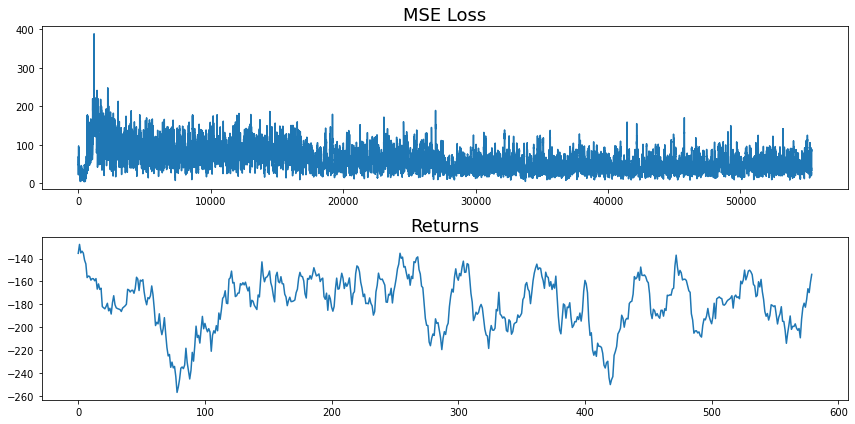

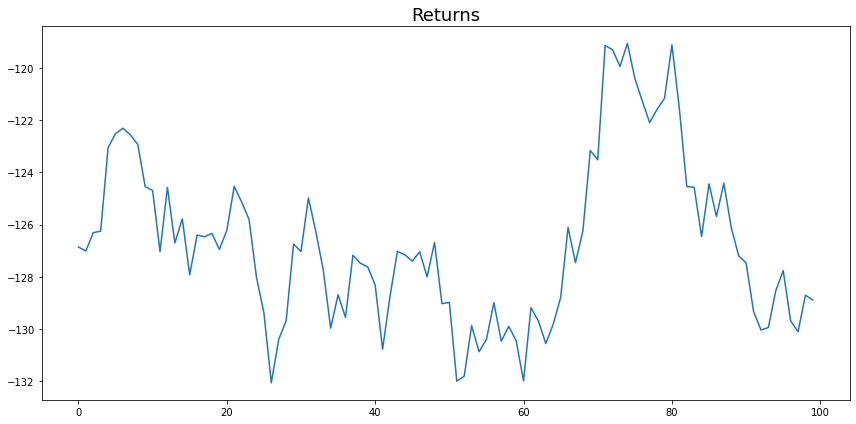

In [106]:




modelnum_new= 0
f = open("{0}_tableh.pkl".format(experiment), 'rb')
tableh = pickle.load(f)
f.close()

alphai= tableh['alpha'].iloc[modelnum_new]
gammai= tableh['gamma'].iloc[modelnum_new]
epsilontypei= tableh['epsilontype'].iloc[modelnum_new]
epsilonmin= tableh['epsilonmin'].iloc[modelnum_new]


print("alpha",alphai, "gamma",gammai, "epsilondecay" ,epsilontypei, "epsilonmin", epsilonmin, "batch", batchi)

f = open("{0}_modelnum{1}.pkl".format(experiment,modelnum_new), 'rb')
all = pickle.load(f)
f.close()
q_network=all['q_network']
stats = all['stats']

f = open("{0}_modelnum{1}_eval.pkl".format(experiment, modelnum_new), 'rb')
stats2 = pickle.load(f)
f.close()
#stats2=all2['Returns']
plot_stats(stats)
plot_stats(stats2)





In [ ]:
stats2

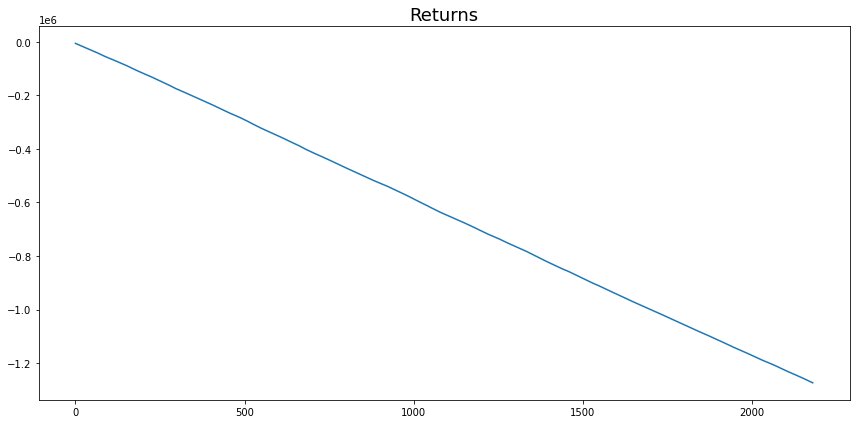

In [ ]:
plot_stats(stats2)